In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import matplotlib.pyplot as plt

import torch
import numpy as np
from tqdm import tqdm

from tools.signals import get_bpm_and_phase_shift_fft, mean_without_outliers, mean_without_outliers_using_std, SignalSmoother
from tools.video import load_video_frames, resize_frames

from tools.globals import VIDEOS_DIR

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [28]:
video_number = 728
video_start = 0
video_end = 37

left_video_path = ""
right_video_path = ""

# DOLL VIDEOS
vid_file = 'RR 20 PA 90 03.04.22_color_0_30.avi'
rgb_video_path = os.path.join(VIDEOS_DIR,"doll", vid_file)

# REGULAR VIDEOS
# vid_file = 'WOBI_728_color_0_37.avi' # SHOW THIS
# vid_file = 'WOBI_233_color_0_32.avi'
# rgb_video_path = os.path.join(VIDEOS_DIR, vid_file)


left_frames, right_frames, rgb_frames, (left_fps, right_fps, rgb_fps) = load_video_frames(left_video_path, right_video_path, rgb_video_path)

for i, frame in enumerate(rgb_frames):
    # new_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    new_frame = frame.astype(float) / 255.0  # Normalize to [0,1]
    rgb_frames[i] = new_frame

rgb_frames = np.array(rgb_frames)
rgb_frames = resize_frames(rgb_frames)


/mnt/gipnetapp_public/DnD/Videos/doll/RR 20 PA 90 03.04.22_color_0_30.avi


757it [00:00, 1346.72it/s]


In [3]:
print(rgb_frames[0].shape)
print(len(rgb_frames))
print(rgb_fps)
print(f"Video Duration:{len(rgb_frames) / rgb_fps}")
USE_ROLLING_DEPTH = True
# fixing good start & end according to researcher
# Default values:
good_start = 0
good_end = len(rgb_frames)
# Not Default
# good_start = int(8.12 * rgb_fps)
# good_end = int(28.33 * rgb_fps)

# good_start = 0
# good_end = 31.167
print(f"Start: {good_start}, End:{good_end}")

(720, 1280, 3)
757
25.233
Video Duration:30.000396306424125
Start: 0, End:757


In [4]:
from skimage.metrics import structural_similarity as compare_ssim
from tools.process import Pipeline
depths = []
THRESHOLDING = False
threshold = 2
thresh_ratio = 0.1
pipeline = Pipeline(vid_file, good_start, good_end)

if USE_ROLLING_DEPTH:
    depths = pipeline.load_depths()
else:
    ref_frame = rgb_frames[0]
    depth = np.zeros((720, 1280, 2))
    max_outliers_num = 0
    for i in tqdm(range(len(rgb_frames)-1)):
        if THRESHOLDING:
            # Calculating magnitude for each pixel + mean/std
            mag = np.linalg.norm(depth,axis=2)
            mag_mean = np.mean(mag)
            mag_std = np.std(mag)

            # Count outliers
            outlier_mask = np.abs(mag - mag_mean) > threshold * mag_std
            num_outliers = np.sum(outlier_mask)

            if num_outliers > mag.shape[0] * mag.shape[1] * thresh_ratio:
                ref_frame = rgb_frames[i]
                print("Updated frame")
        # Load two images
        image1 = ref_frame
        image2 = rgb_frames[i]
        # print(rgb_frames.shape)
        ssim, _ = compare_ssim(ref_frame, rgb_frames[i], full=True, multichannel=True)
        
        # Estimate flow between images
        depth = flow_estimator.estimate_flow(image1, image2)
    
        depths.append(depth)
        

/mnt/gipnetapp_public/DnD/Videos/doll/RR 20 PA 90 03.04.22_color_0_30.avi
Loading depths complete


757it [00:00, 1632.10it/s]


Resizing depths complete


In [5]:
from tools.video import resize_frames
depths = np.array(depths)
print(depths.shape)
new_depths = np.zeros(depths.shape[:3])
if not USE_ROLLING_DEPTH:
    for i,depth in enumerate(depths):
        new_depths[i] = np.linalg.norm(depth,axis=2)
    depths = new_depths
depths = resize_frames(depths)


(757, 720, 1280)


757it [00:01, 654.23it/s]


In [6]:
from tools.process import Pipeline
pipeline = Pipeline(vid_file, good_start, good_end)
segmentations = pipeline.load_video_segmentation()

/mnt/gipnetapp_public/DnD/Videos/doll/RR 20 PA 90 03.04.22_color_0_30.avi
Loading Segmentation...


757it [00:00, 1914.91it/s]


Loading Segmentation complete.


In [7]:
from tools.video import seperate_masks_to_abdomen_and_chest, resize_frames, apply_masks_erosion

abdomen_masks, chest_masks, _ = seperate_masks_to_abdomen_and_chest(segmentations)
no_erosion_chest_masks = [mask.copy() for mask in chest_masks]
no_erosion_abdomen_masks = [mask.copy() for mask in abdomen_masks]

abdomen_masks, chest_masks = apply_masks_erosion(abdomen_masks, chest_masks)

# first_frame = rgb_frames[0]
# first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)  # Convert explicitly

# plt.imshow(first_frame)

# curr_chest_depth = chest_masks[0]*depths[0]
# curr_chest_depth = np.ma.masked_where(curr_chest_depth == 0, curr_chest_depth)        
# plt.imshow(curr_chest_depth)


# curr_abdomen_depth = abdomen_masks[0]*depths[0]
# curr_abdomen_depth = np.ma.masked_where(curr_abdomen_depth == 0, curr_abdomen_depth)        

# plt.imshow(curr_abdomen_depth)
# plt.show()
# plt.imshow(chest_masks[0]*depths[0])

In [8]:
from tools.video import get_masked_depths

# GET ALL DEPTHS RELATED VALUES
abdomen_depths, abdomen_depths_avg, abdomen_depths_no_erosion, abdomen_depths_for_vid = get_masked_depths(abdomen_masks, no_erosion_abdomen_masks, depths, is_chest=False) 
chest_depths, chest_depths_avg, chest_depths_no_erosion, chest_depths_for_vid = get_masked_depths(chest_masks, no_erosion_chest_masks, depths, is_chest=True)


757it [00:24, 30.44it/s]
757it [00:40, 18.68it/s]


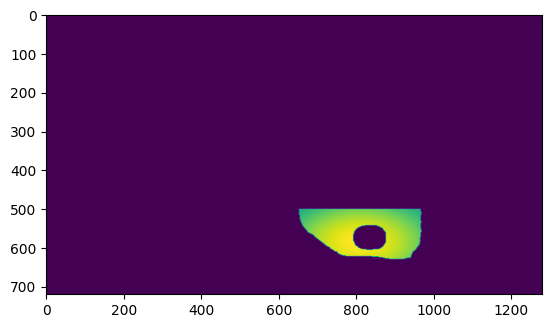

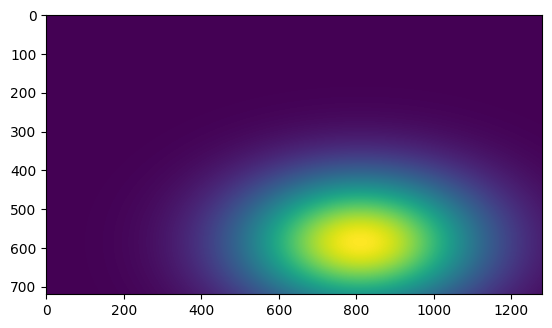

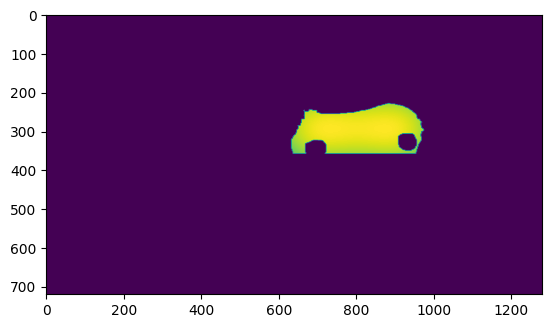

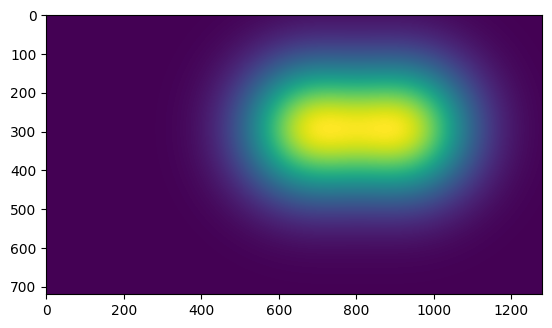

In [9]:
from tools.video import gaussian_weighted_average_for_abdomen, gaussian_weighted_average_for_chest

weighted_avg, weights = gaussian_weighted_average_for_abdomen(abdomen_masks[0], depths[0])
plt.imshow(abdomen_masks[0] * weights)
plt.show()
plt.imshow(weights)
plt.show()

weighted_avg, weights = gaussian_weighted_average_for_chest(chest_masks[0], depths[0])
plt.imshow(chest_masks[0]*weights)
plt.show()
plt.imshow(weights)



In [10]:
import json
from tools.globals import ANNOTATIONS_DIR
annot_dir = os.path.join(ANNOTATIONS_DIR, f"{vid_file.split('.avi')[0]}_annotations.json")

with open(annot_dir) as f:
    gt = json.load(f)
    
gt["chest_peaks"] = sorted(gt["chest_peaks"], key=lambda x: x["frame_number"])
gt["abdomen_peaks"] = sorted(gt["abdomen_peaks"], key=lambda x: x["frame_number"])


In [11]:
# Peaks from the dictionary
if gt:
    chest_peaks = [peak['frame_number'] -  pipeline.start_frame for peak in gt['chest_peaks'] if peak['frame_number'] <= pipeline.end_frame and peak['frame_number'] >= pipeline.start_frame]
    abdomen_peaks = [peak['frame_number'] -  pipeline.start_frame for peak in gt['abdomen_peaks'] if peak['frame_number'] <= pipeline.end_frame and peak['frame_number'] >= pipeline.start_frame]
print(gt["chest_peaks"])
print(f"Good end:{pipeline.end_frame}, Good Start:{pipeline.start_frame}")

[{'frame_number': 58, 'timestamp': '02:298'}, {'frame_number': 141, 'timestamp': '05:587'}, {'frame_number': 215, 'timestamp': '08:520'}, {'frame_number': 288, 'timestamp': '11:413'}, {'frame_number': 361, 'timestamp': '14:306'}, {'frame_number': 436, 'timestamp': '17:278'}, {'frame_number': 505, 'timestamp': '20:013'}, {'frame_number': 578, 'timestamp': '22:906'}, {'frame_number': 652, 'timestamp': '25:839'}, {'frame_number': 724, 'timestamp': '28:692'}]
Good end:19101, Good Start:0


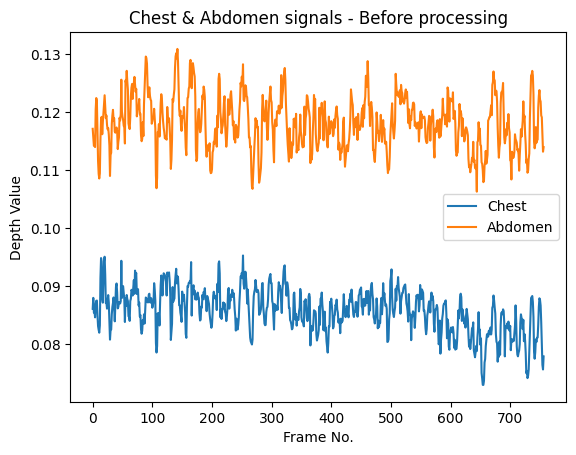

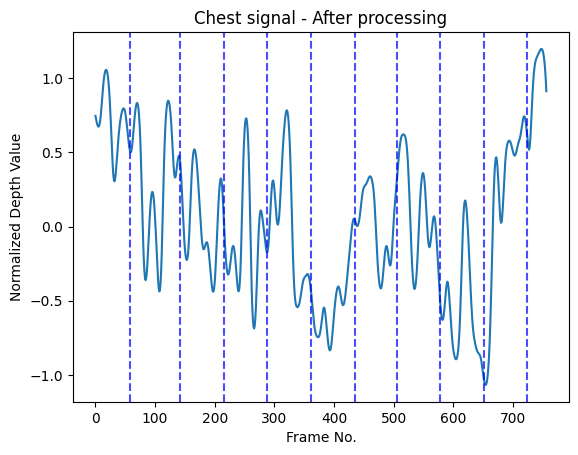

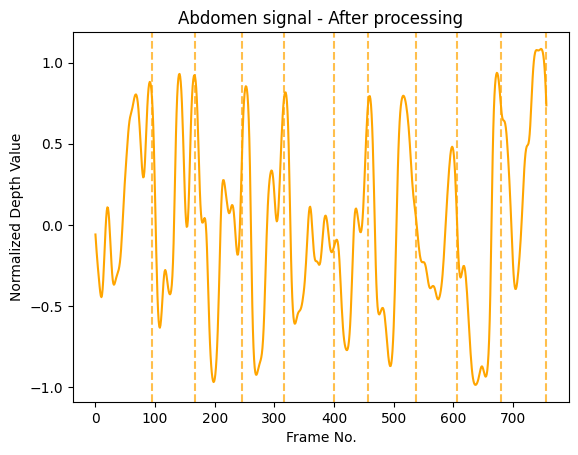

In [12]:
chest_signal = np.array(chest_depths)
chest_avg_signal = np.array(chest_depths_avg)
chest_no_erosion_signal = np.array(chest_depths_no_erosion)

abdomen_signal = np.array(abdomen_depths)
abdomen_avg_signal = np.array(abdomen_depths_avg)
abdomen_no_erosion_signal = np.array(abdomen_depths_no_erosion)

plt.title("Chest & Abdomen signals - Before processing")
plt.plot(chest_signal, label="Chest")

plt.plot(abdomen_signal, label="Abdomen")
plt.legend()
plt.xlabel('Frame No.')
plt.ylabel('Depth Value')

plt.show()

smoother = SignalSmoother(rgb_fps)
smoothed_chest_signal = smoother.process(chest_signal)
smoothed_chest_avg_signal = smoother.process(chest_avg_signal)
smoothed_chest_no_erosion_signal = smoother.process(chest_no_erosion_signal)

smoothed_abdomen_signal = smoother.process(abdomen_signal)
smoothed_abdomen_avg_signal = smoother.process(abdomen_avg_signal)
smoothed_abdomen_no_erosion_signal = smoother.process(abdomen_no_erosion_signal)

plt.title("Chest signal - After processing")
plt.plot(smoothed_chest_signal)
# plt.plot(smoothed_chest_avg_signal)
for peak in chest_peaks:
    plt.axvline(x=peak, color='blue', linestyle='--', alpha=0.7, label='Chest Peak' if peak == chest_peaks[0] else "")
# plt.plot(chest_x, chest_y, label="Chest Annotation", color="green")
plt.xlabel('Frame No.')
plt.ylabel('Normalized Depth Value')
plt.show()
plt.title("Abdomen signal - After processing")
plt.plot(smoothed_abdomen_signal, color='orange')
# plt.plot(smoothed_abdomen_avg_signal)
for peak in abdomen_peaks:
    plt.axvline(x=peak, color='orange', linestyle='--', alpha=0.7, label='Abdomen Peak' if peak == abdomen_peaks[0] else "")
# plt.plot(abdomen_x, abdomen_y, label="Chest Annotation", color="green")
plt.xlabel('Frame No.')
plt.ylabel('Normalized Depth Value')

plt.show()

150


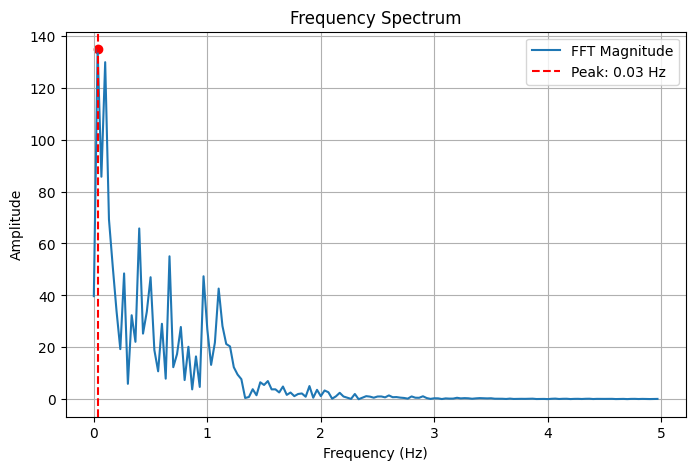

In [13]:
def plot_fft(signal, sampling_rate):
    N = len(signal)
    
    # Compute FFT
    fft_values = np.fft.fft(signal)
    freq_bins = np.fft.fftfreq(N, d=1/sampling_rate)  # Frequency values
    
    # Compute magnitude spectrum
    magnitude = np.abs(fft_values)
    
    # Find the peak frequency
    positive_frequencies = freq_bins[:N//2][:150]
    positive_magnitudes = magnitude[:N//2][:150]
    peak_index = np.argmax(positive_magnitudes)
    peak_freq = positive_frequencies[peak_index]
    print(len(positive_frequencies))
    peak_amp = positive_magnitudes[peak_index]
    
    # Plot frequency vs amplitude
    plt.figure(figsize=(8, 5))
    plt.plot(positive_frequencies, positive_magnitudes, label="FFT Magnitude")
    
    # Mark the peak frequency
    plt.axvline(x=peak_freq, color='r', linestyle='--', label=f'Peak: {peak_freq:.2f} Hz')
    plt.scatter([peak_freq], [peak_amp], color='red')  # Mark peak point
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Frequency Spectrum")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
sampling_rate = rgb_fps  # Hz
# signal = np.sin(2 * np.pi * 10 * np.linspace(0, 1, sampling_rate))  # Example 10 Hz sine wave
plot_fft(smoothed_chest_signal, sampling_rate)

In [21]:
from tools.signals import calc_bpm_and_phase_shift_fft, RR_and_PA_from_json

chest_RR, abdomen_RR, PA = calc_bpm_and_phase_shift_fft(smoothed_chest_signal, smoothed_abdomen_signal, rgb_fps)

print(f"Chest RR: {chest_RR}, Abdomen RR:{abdomen_RR} PA: {PA}")

annot_chest_RR, annot_abdomen_RR, annot_PA = RR_and_PA_from_json(annot_dir)

print(f"Annotated Chest RR: {annot_chest_RR}, Annotated Abdomen RR:{annot_abdomen_RR} Annotated PA: {annot_PA}")

Chest RR: 27.27777944862155, Abdomen RR:20.026190476190468 PA: 30.19581836061109
Annotated Chest RR: 20.026598863905434, Annotated Abdomen RR:20.026598863905434 Annotated PA: 144.52351865122398


In [31]:
from tools.video import create_segmented_frames, get_folder_name
# CREATE SEGMENETED FRAMES
# print(vid_file)
# file_name = get_folder_name(vid_file)[1]
file_name = "RR_20_PA_90"
seg_frames = create_segmented_frames(rgb_frames, chest_depths_for_vid, abdomen_depths_for_vid, file_name, chest_RR, abdomen_RR, PA, annot_chest_RR, annot_abdomen_RR, annot_PA)
# seg_frames = create_segmented_frames(rgb_frames, chest_depths_for_vid, abdomen_depths_for_vid, file_name, chest_RR, abdomen_RR, PA)

In [30]:
from tools.process import Pipeline
import json
from tools.VideoData import VideoData
# vids_dir = os.path.join(VIDEOS_DIR, "avoid")
# vids_dir = os.path.join(VIDEOS_DIR, "doll")
vid_files = [vid_file]

# vid_files = [f for f in os.listdir(vids_dir) if os.path.isfile(os.path.join(vids_dir, f))]
vid_files = sorted(vid_files)
for vid_file in vid_files:
    try:
        pipline = Pipeline(vid_file, good_start, good_end)
        saved_signal_frames = pipline.save_signals(smoothed_abdomen_signal, smoothed_chest_signal, abdomen_peaks, chest_peaks)
        pipeline.save_video(saved_signal_frames, seg_frames)
        v_data = VideoData(pipline.file_name, pipline.folder_name, chest_signal = smoothed_chest_signal, abdomen_signal = smoothed_abdomen_signal)
        pipline.save_json_data(v_data)
    except Exception as e:
        print(e)
        with open('/mnt/gipnetapp_public/DnD/errors.txt', 'a') as f:
            f.write(f"{vid_file} has failed with error: {str(e)}\n")



/mnt/gipnetapp_public/DnD/Videos/doll/RR 20 PA 90 03.04.22_color_0_30.avi


757it [01:14, 10.14it/s]


Moviepy - Building video /mnt/gipnetapp_public/DnD/Outputs/Results/RR 20 PA 90 03.04.22_color_0_30/RR 20 PA 90 03.04.22_color_0_30_combined_v2.mp4.
Moviepy - Writing video /mnt/gipnetapp_public/DnD/Outputs/Results/RR 20 PA 90 03.04.22_color_0_30/RR 20 PA 90 03.04.22_color_0_30_combined_v2.mp4



Moviepy - Done !
Moviepy - video ready /mnt/gipnetapp_public/DnD/Outputs/Results/RR 20 PA 90 03.04.22_color_0_30/RR 20 PA 90 03.04.22_color_0_30_combined_v2.mp4
Saved video: RR 20 PA 90 03.04.22_color_0_30.avi
Json data has been saved


In [ ]:
print(len(seg_frames), len(saved_signal_frames))
print(seg_frames[0], saved_signal_frames[0])
